In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ------------------------------
# Step 1: Save Uppercase Letters A-Z
# ------------------------------
def save_emnist_letters(csv_path, output_dir, split_name, img_size=(32, 32)):
    os.makedirs(output_dir, exist_ok=True)
    print(f"🔄 Converting {split_name} A–Z character data...")

    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values.astype(int)
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')

    # Filter only A–Z uppercase characters: labels 10–35
    letter_indices = np.where((labels >= 10) & (labels <= 35))[0]
    labels = labels[letter_indices]
    images = images[letter_indices]

    for idx, (label, image) in enumerate(tqdm(zip(labels, images), total=len(labels))):
        # Map 10–35 to A–Z using ASCII
        class_char = chr(label + 55)  # chr(65) = 'A'

        label_dir = os.path.join(output_dir, split_name, class_char)
        os.makedirs(label_dir, exist_ok=True)

        # ✅ Fix EMNIST orientation
        image = np.transpose(image, (1, 0))  # Rotate -90
        
        image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)
        img_path = os.path.join(label_dir, f"{idx}.png")
        cv2.imwrite(img_path, image)

# ------------------------------
# Step 2: Convert Train/Test
# ------------------------------
train_csv = '/kaggle/input/emnist/emnist-byclass-train.csv'
test_csv = '/kaggle/input/emnist/emnist-byclass-test.csv'
output_base = './emnist_az_images'

save_emnist_letters(train_csv, output_base, 'train')
save_emnist_letters(test_csv, output_base, 'test')

print("✅ A–Z letter images saved with correct orientation!")

🔄 Converting train A–Z character data...


100%|██████████| 188958/188958 [00:25<00:00, 7468.30it/s]


🔄 Converting test A–Z character data...


100%|██████████| 31346/31346 [00:04<00:00, 7668.58it/s]

✅ A–Z letter images saved with correct orientation!


In [2]:
# ------------------------------
# Step 3: Split Train → Train + Val (15%)
# ------------------------------
print("🔧 Splitting train into train + val...")

train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
os.makedirs(val_dir, exist_ok=True)

for char_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, char_class)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.15, random_state=42)

    val_class_dir = os.path.join(val_dir, char_class)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in val_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_class_dir, img)
        os.rename(src, dst)

print("✅ Split completed. Train, Val, and Test sets created.")

🔧 Splitting train into train + val...
✅ Split completed. Train, Val, and Test sets created.


📷 Visualizing from Train Set A–Z Samples...


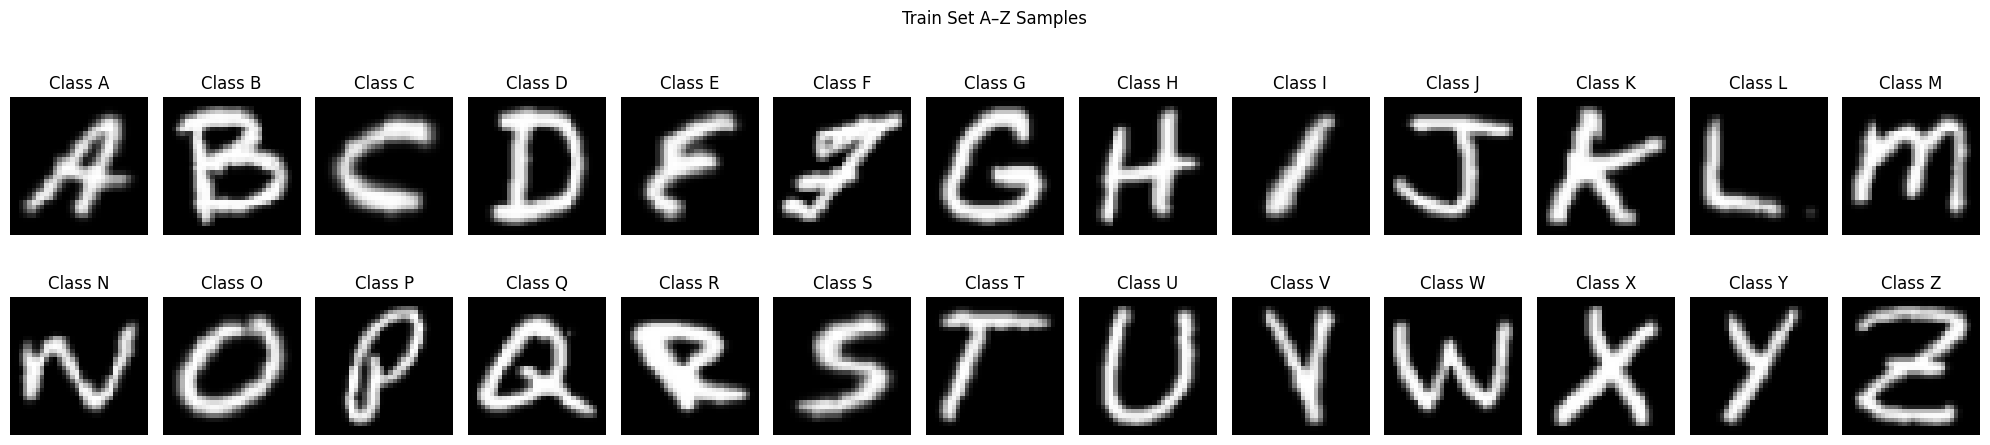

📷 Visualizing from Validation Set A–Z Samples...


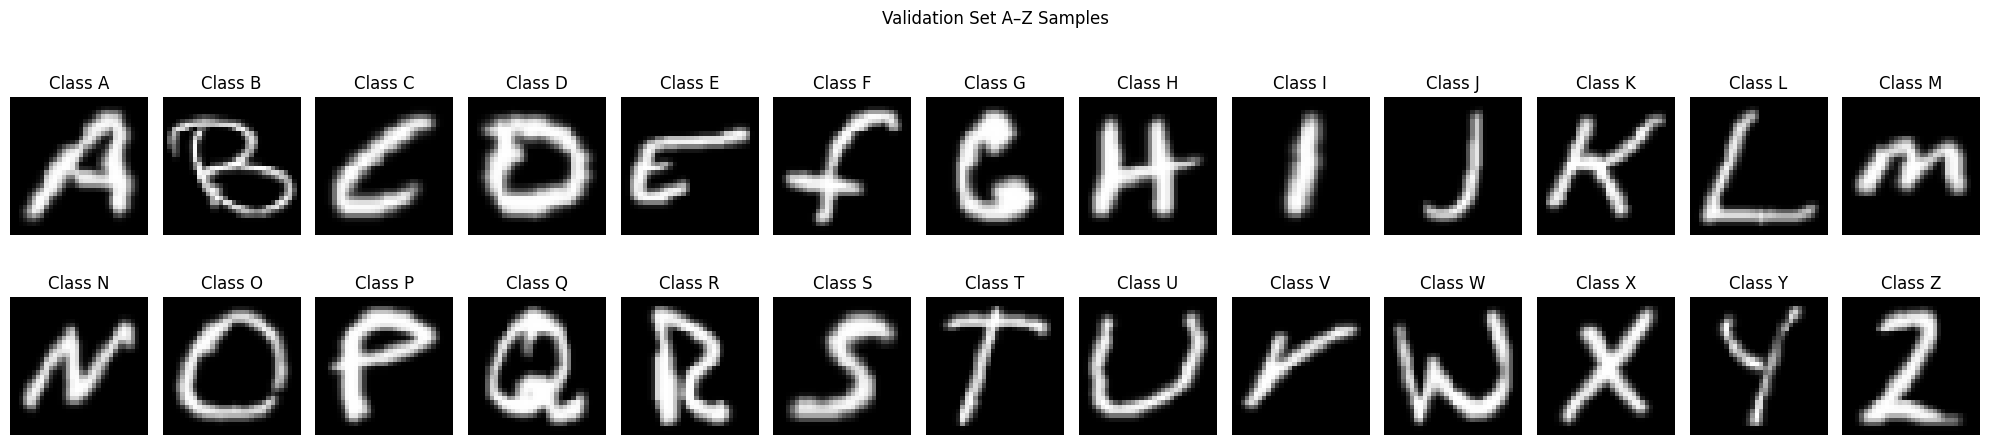

📷 Visualizing from Test Set A–Z Samples...


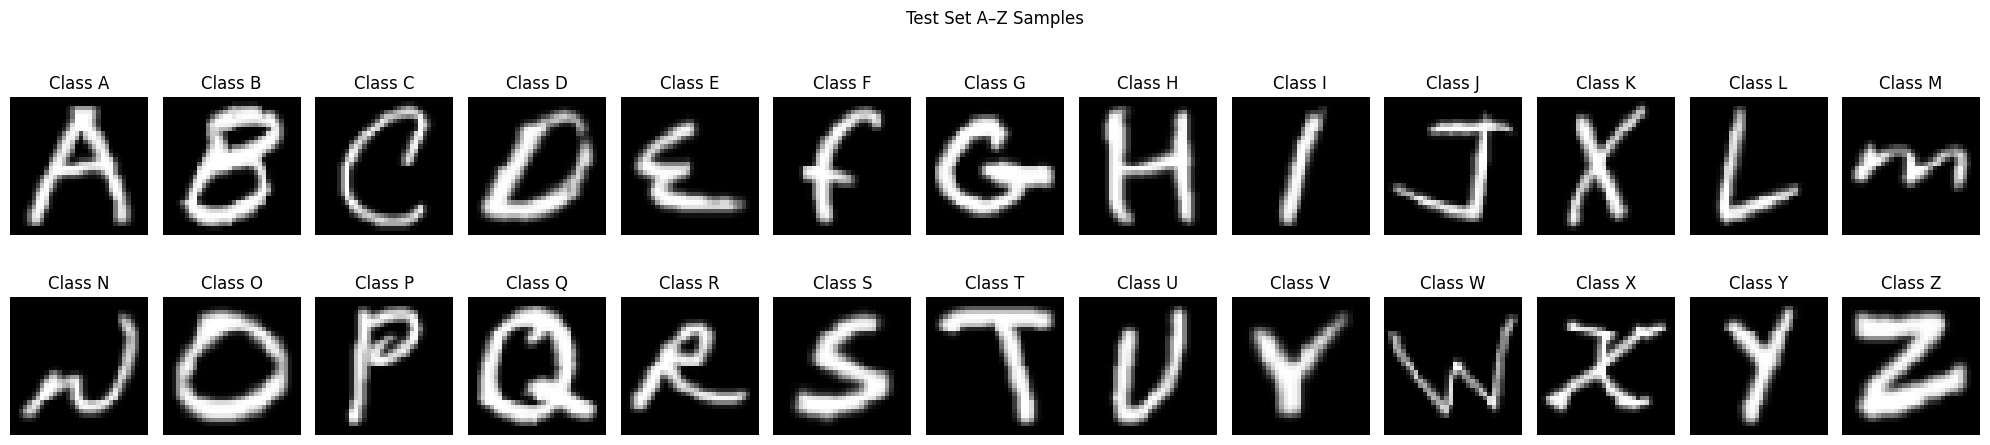

In [3]:
# ------------------------------
# Step 4: Visualize A-Z Samples
# ------------------------------
def visualize_samples_from_folder(folder, title, num_classes=26):
    print(f"📷 Visualizing from {title}...")
    plt.figure(figsize=(20, 5))
    shown = 0
    for class_name in sorted(os.listdir(folder))[:num_classes]:
        class_dir = os.path.join(folder, class_name)
        if not os.path.isdir(class_dir):
            continue
        images = os.listdir(class_dir)
        if not images:
            continue
        img_path = os.path.join(class_dir, images[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(2, 13, shown + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class {class_name}")
        plt.axis('off')
        shown += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_samples_from_folder(os.path.join(output_base, 'train'), "Train Set A–Z Samples")
visualize_samples_from_folder(os.path.join(output_base, 'val'), "Validation Set A–Z Samples")
visualize_samples_from_folder(os.path.join(output_base, 'test'), "Test Set A–Z Samples")


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---------------------------------------------
# Step 2.2: Load Digit Dataset with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 80
num_classes = 26  # Digits 0–9

# Path where you saved the digit folders (0-9) from EMNIST
train_path = "/kaggle/working/emnist_az_images/train"
val_path   = "/kaggle/working/emnist_az_images/val"
test_path  = "/kaggle/working/emnist_az_images/test"

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    fill_mode='nearest'
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',  # for numerical labels
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

Found 160600 images belonging to 26 classes.
Found 28358 images belonging to 26 classes.
Found 31346 images belonging to 26 classes.


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------
def build_scriptnet(input_shape=(32, 32, 1), num_classes=26):
    inputs = Input(shape=input_shape, name='input_layer')

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)  # Slightly increased dropout

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(1024)(x)  # Increased size
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNetEnhanced')
    return model

print("Model is initialized!")

Model is initialized!


In [7]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749667243.235627      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749667243.236280      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNetEnhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,373,914 (20.50 MB)

 Trainable params: 5,370,074 (20.49 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [8]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=12, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_EMNIST_A-Z_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=80

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749667293.353473     125 service.cc:148] XLA service 0x78d2ec01e670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749667293.354101     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749667293.354119     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749667294.075952     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/2510 ━━━━━━━━━━━━━━━━━━━━ 1:30 36ms/step - accuracy: 0.1293 - loss: 3.5472  

I0000 00:00:1749667301.823125     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2510/2510 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8850 - loss: 0.4041
Epoch 1: val_accuracy improved from -inf to 0.97884, saving model to scriptnet_EMNIST_A-Z_best.h5
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 123s 43ms/step - accuracy: 0.8850 - loss: 0.4040 - val_accuracy: 0.9788 - val_loss: 0.0833 - learning_rate: 0.0010
Epoch 2/80
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9677 - loss: 0.1155
Epoch 2: val_accuracy improved from 0.97884 to 0.97888, saving model to scriptnet_EMNIST_A-Z_best.h5
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 96s 38ms/step - accuracy: 0.9677 - loss: 0.1155 - val_accuracy: 0.9789 - val_loss: 0.0801 - learning_rate: 0.0010
Epoch 3/80
2509/2510 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9726 - loss: 0.0963
Epoch 3: val_accuracy did not improve from 0.97888
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 96s 38ms/step - accuracy: 0.9726 - loss: 0.0963 - val_accuracy: 0.9775 - val_loss: 0.0839 - learning_rate: 0.0010
Epoch 4/80
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - a

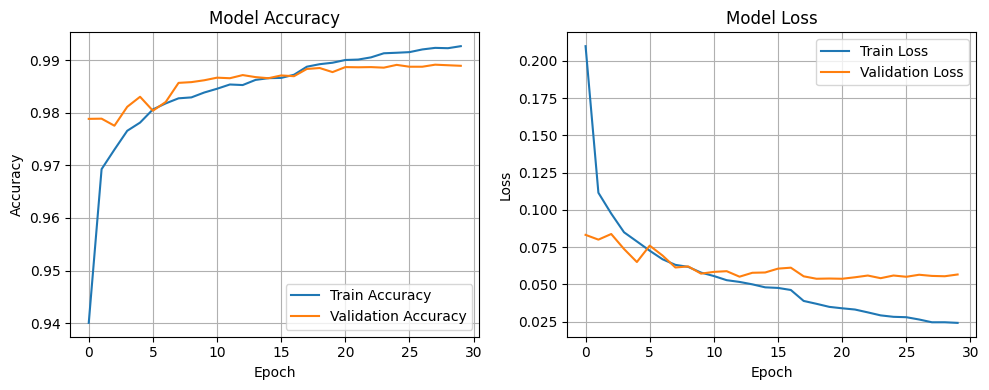

In [9]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

490/490 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step


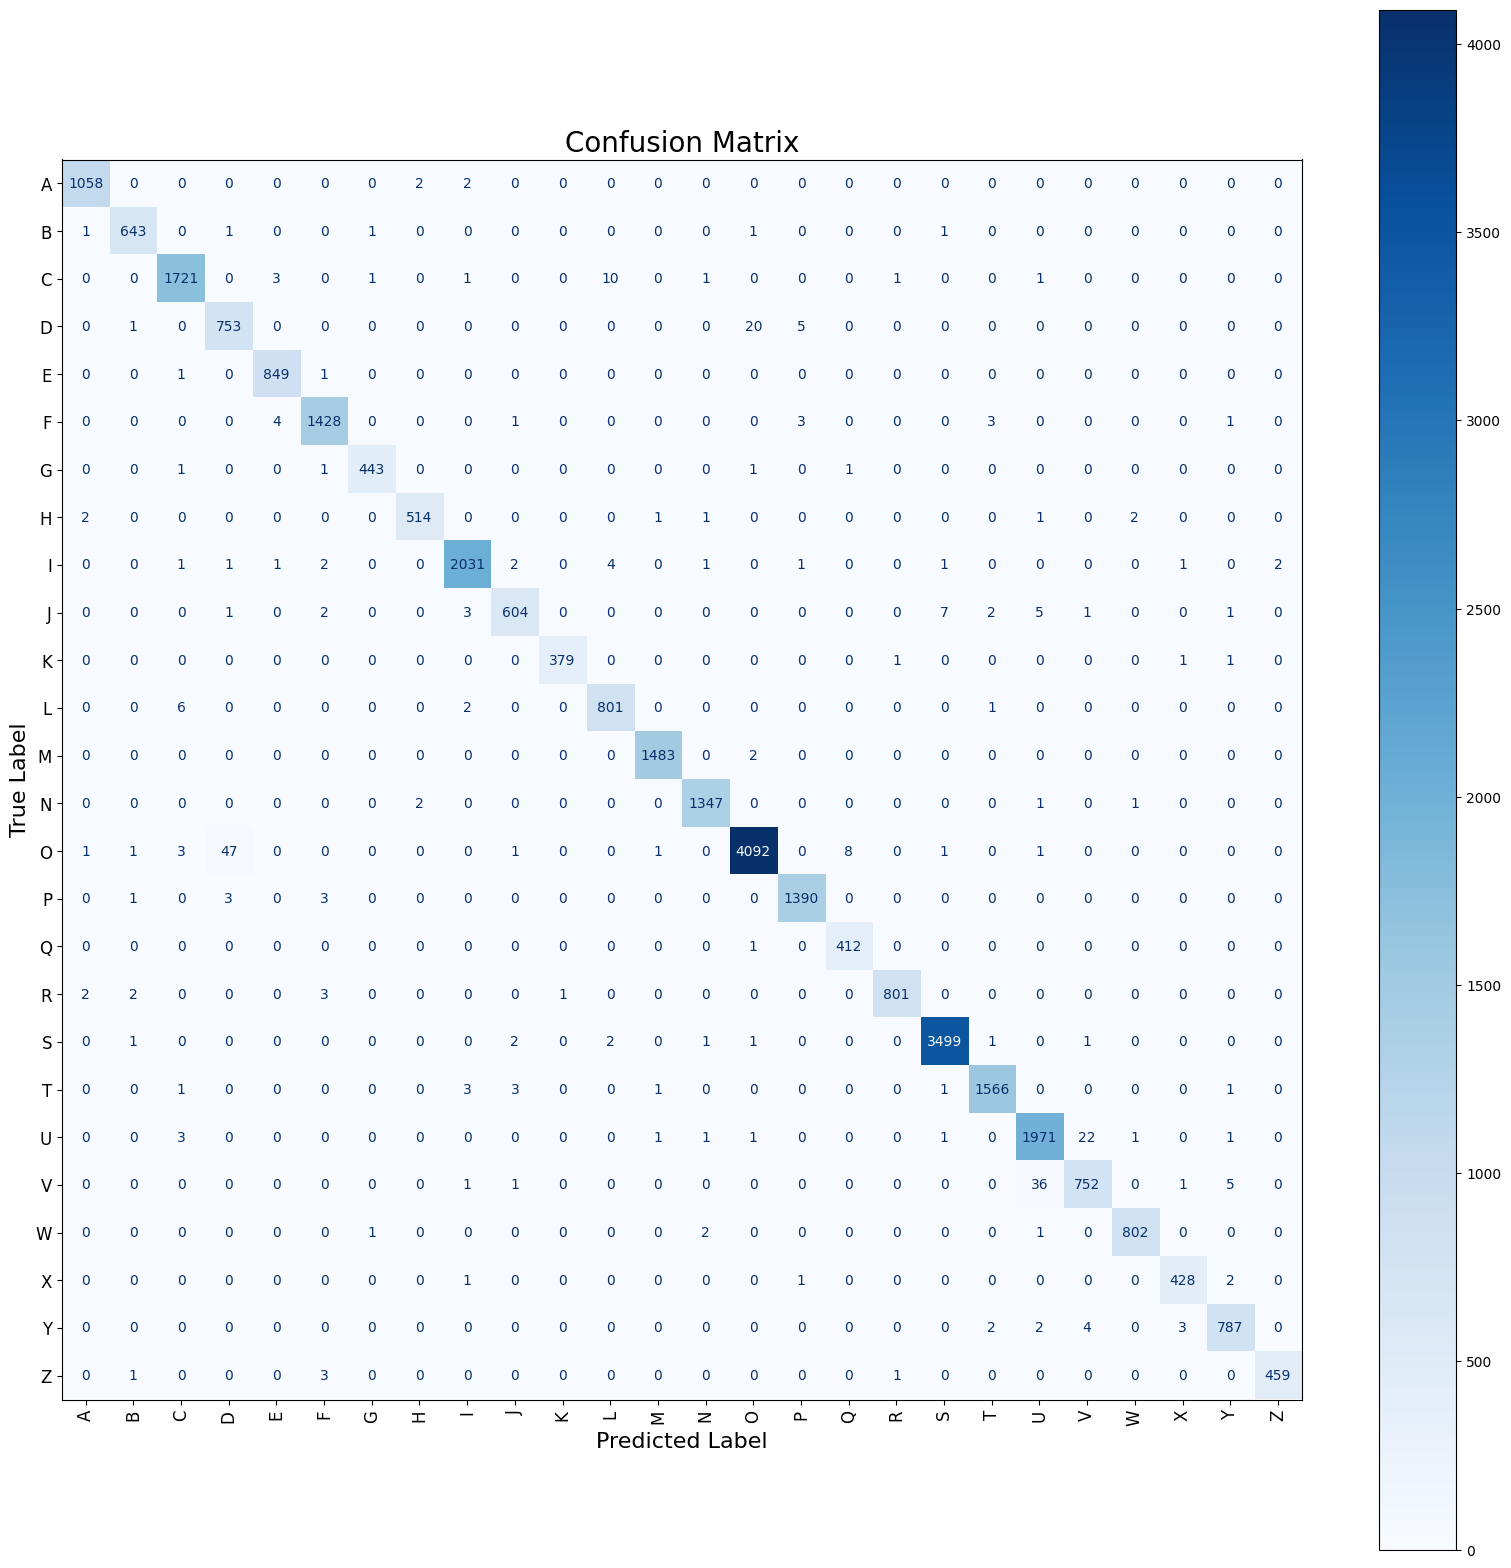

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Create large figure
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust size as needed

# Display Confusion Matrix with custom axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

# Improve font sizes for visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.grid(False)

plt.show()


490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


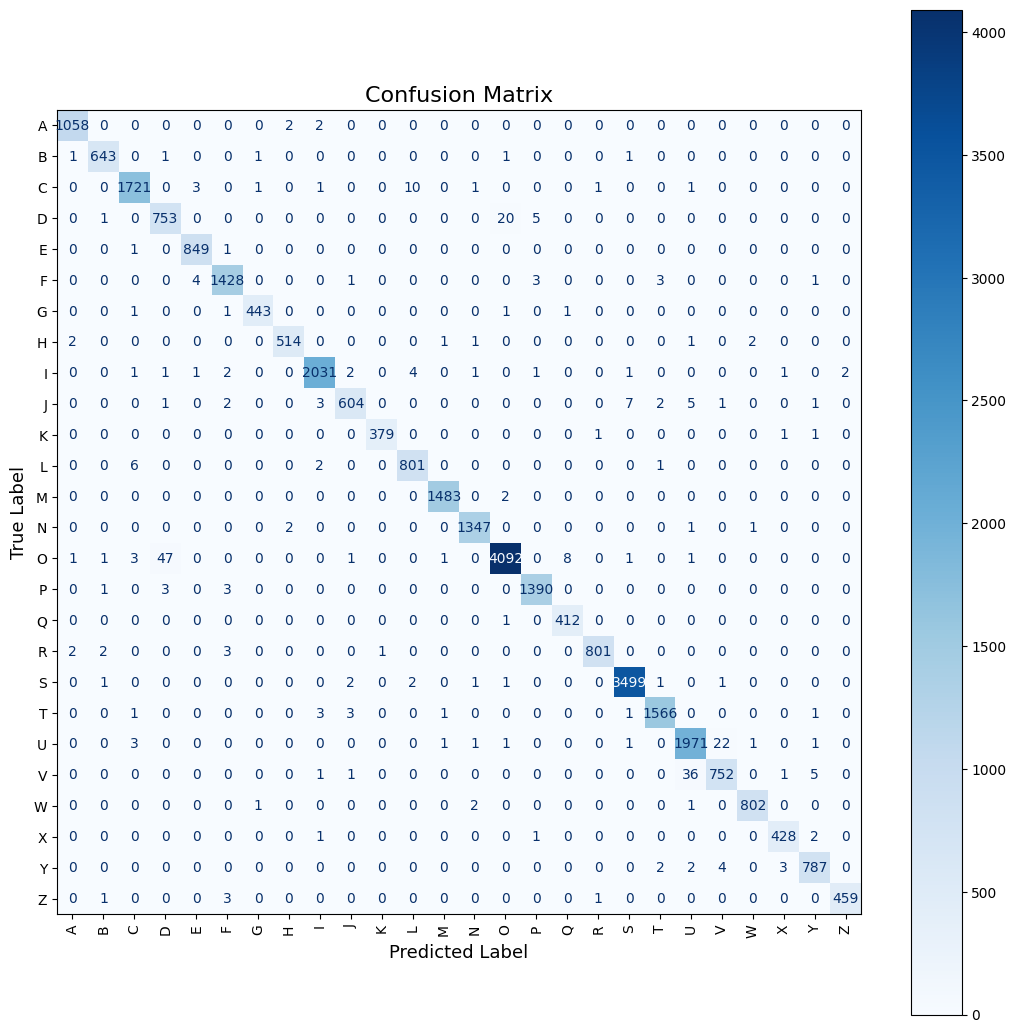

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Create large figure
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust to fit number of classes

# Display Confusion Matrix with custom axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

# Improve font sizes and spacing
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.grid(False)

# Adjust layout so labels are fully visible
plt.tight_layout()
plt.subplots_adjust(left=0.15, bottom=0.15)  # Tweak as needed

plt.show()


490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


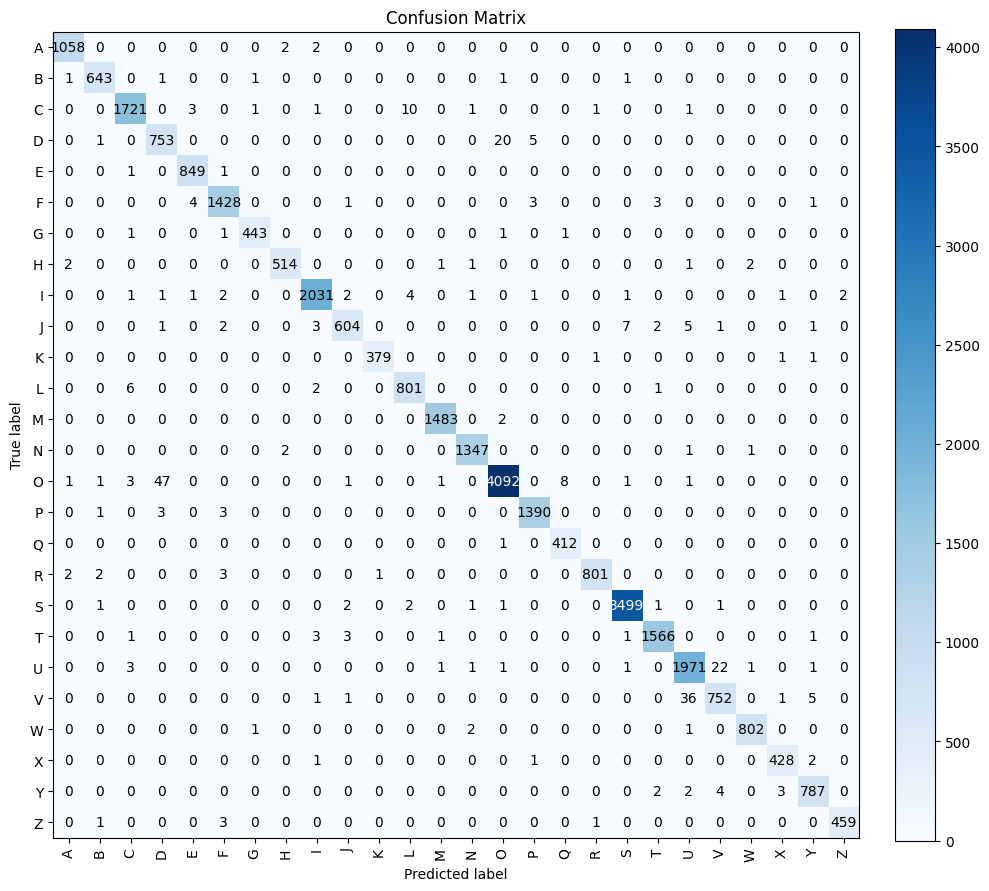

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Create the plot manually to control the layout
fig, ax = plt.subplots(figsize=(10, 10))  # Size based on number of classes
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # ⬅ Match matrix height

# Add labels
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label',
    title="Confusion Matrix"
)

# Rotate the tick labels and set font sizes
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

# Annotate each cell with its count
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


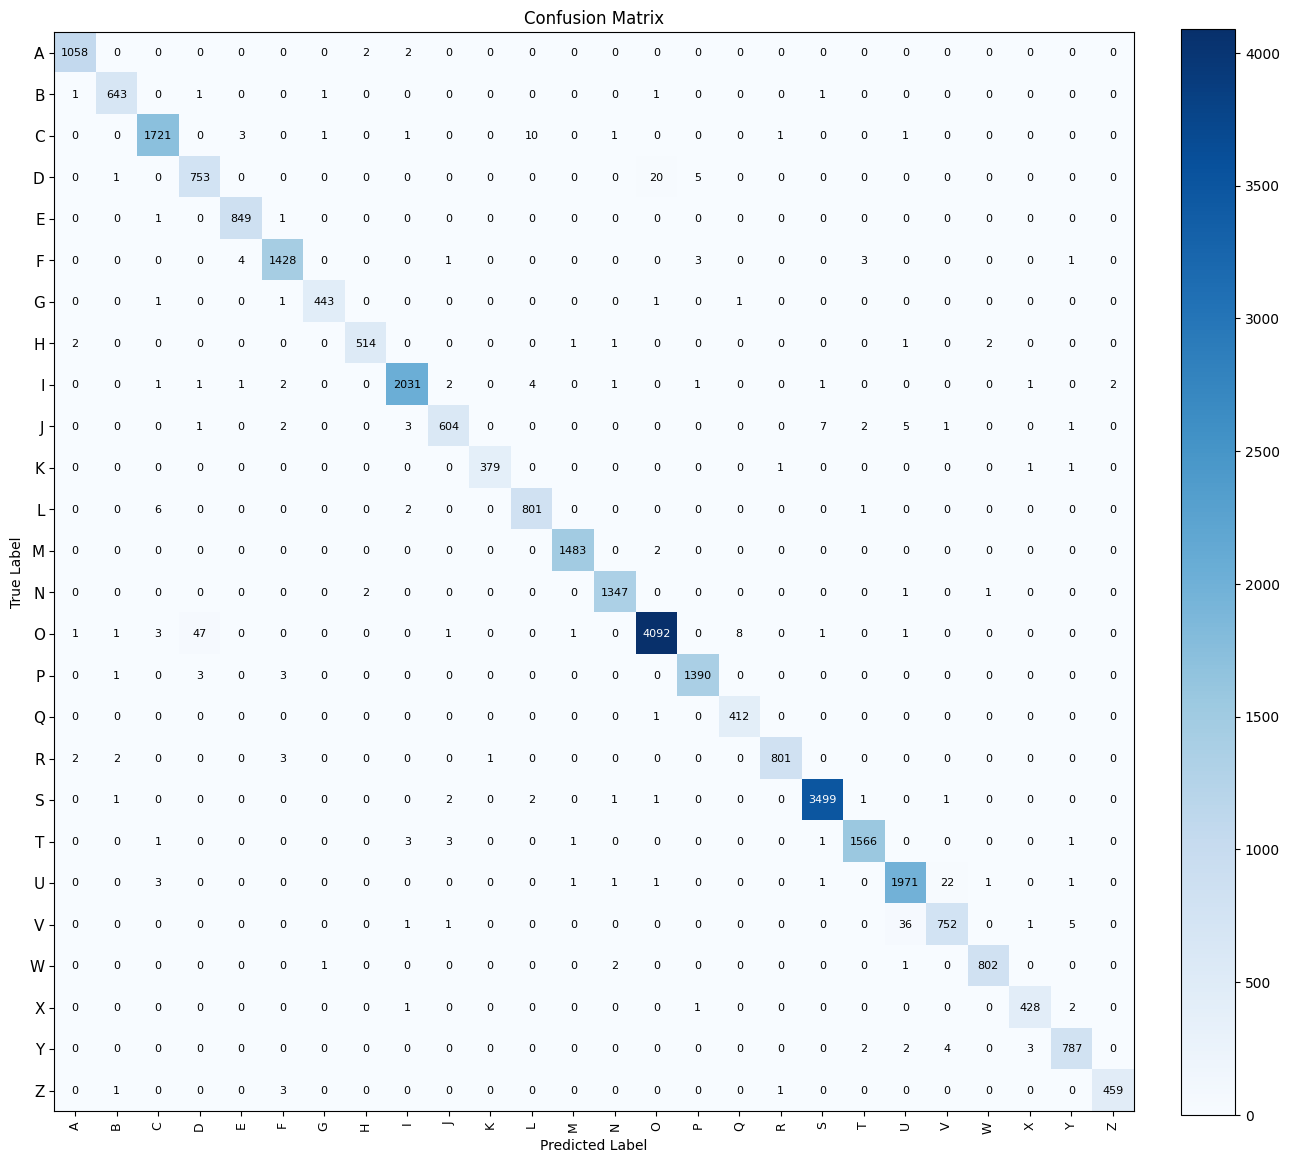

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_general(y_true, y_pred, class_labels, title="Confusion Matrix"):
    num_classes = len(class_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Dynamic figure size
    cell_size = 0.5
    fig_width = max(8, num_classes * cell_size)
    fig_height = max(6, num_classes * cell_size)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Display matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Colorbar adjusted to matrix height
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Set ticks and labels
    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        ylabel='True Label',
        xlabel='Predicted Label',
        title=title
    )

    # Rotate tick labels if too many classes
    if num_classes > 10:
        plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=9)
    else:
        plt.setp(ax.get_xticklabels(), fontsize=11)
    plt.setp(ax.get_yticklabels(), fontsize=11)

    # Annotate each cell
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=8)

    plt.tight_layout()
    plt.show()

# ================================
# Example usage
# ================================
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix_general(y_true, y_pred, class_labels)


490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


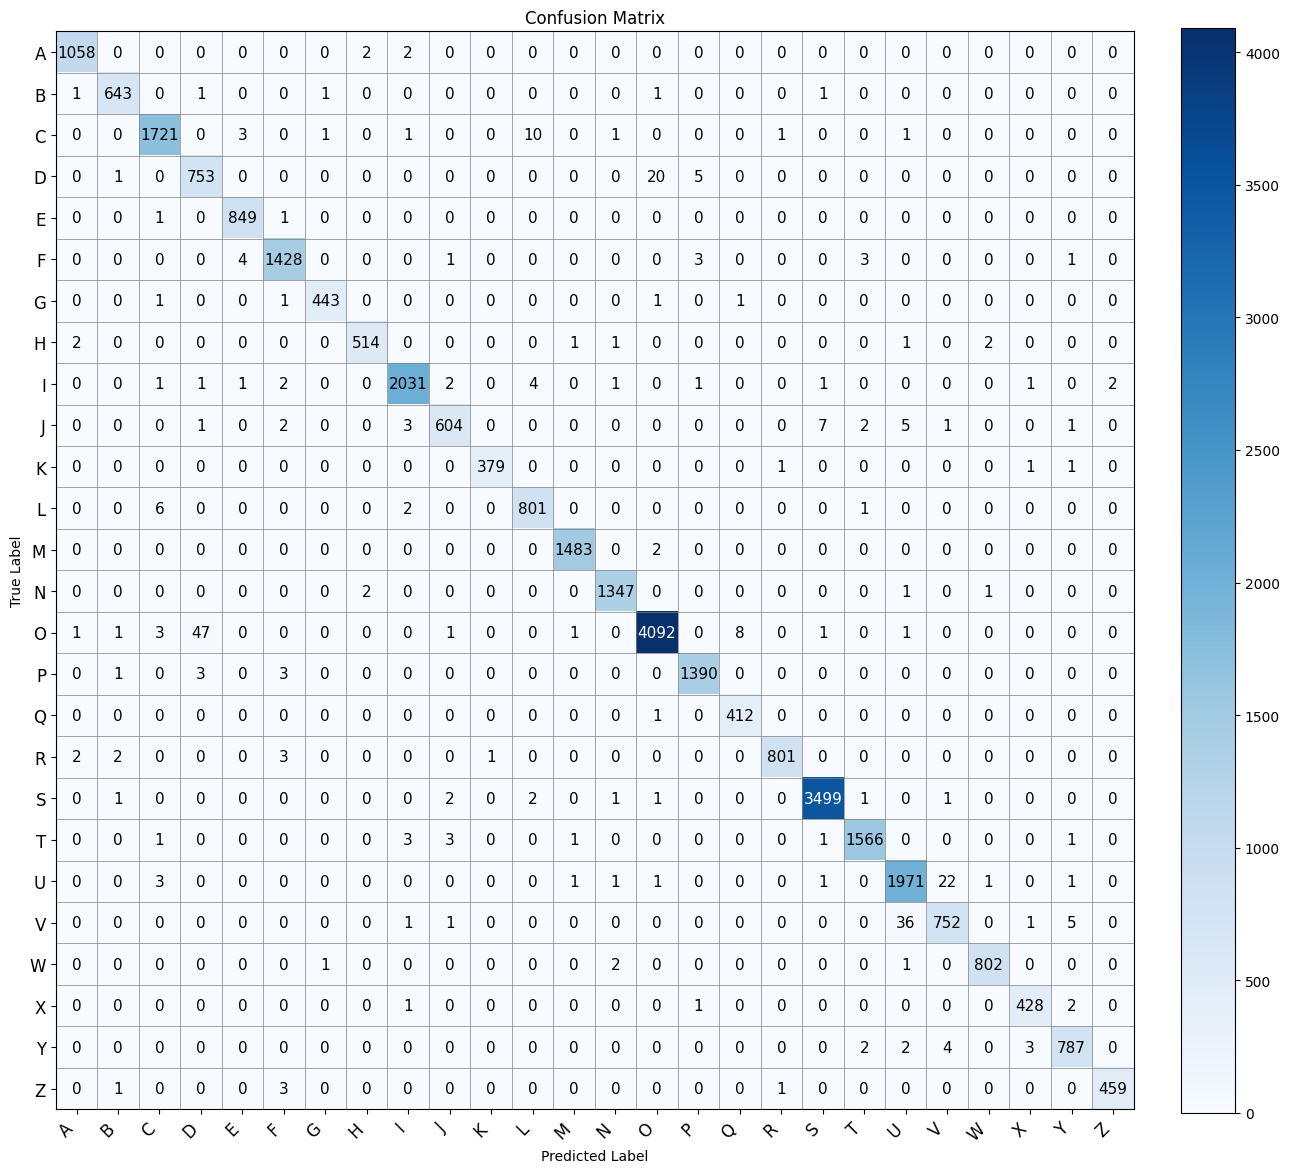

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues'
):
    num_classes = len(class_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Dynamic figure size
    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot the matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    # Tick labels and titles
    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    # Tick styling
    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    # Draw grid lines
    ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotate cells
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()
# Example usage (in your notebook):
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix_general(y_true, y_pred, class_labels)

490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


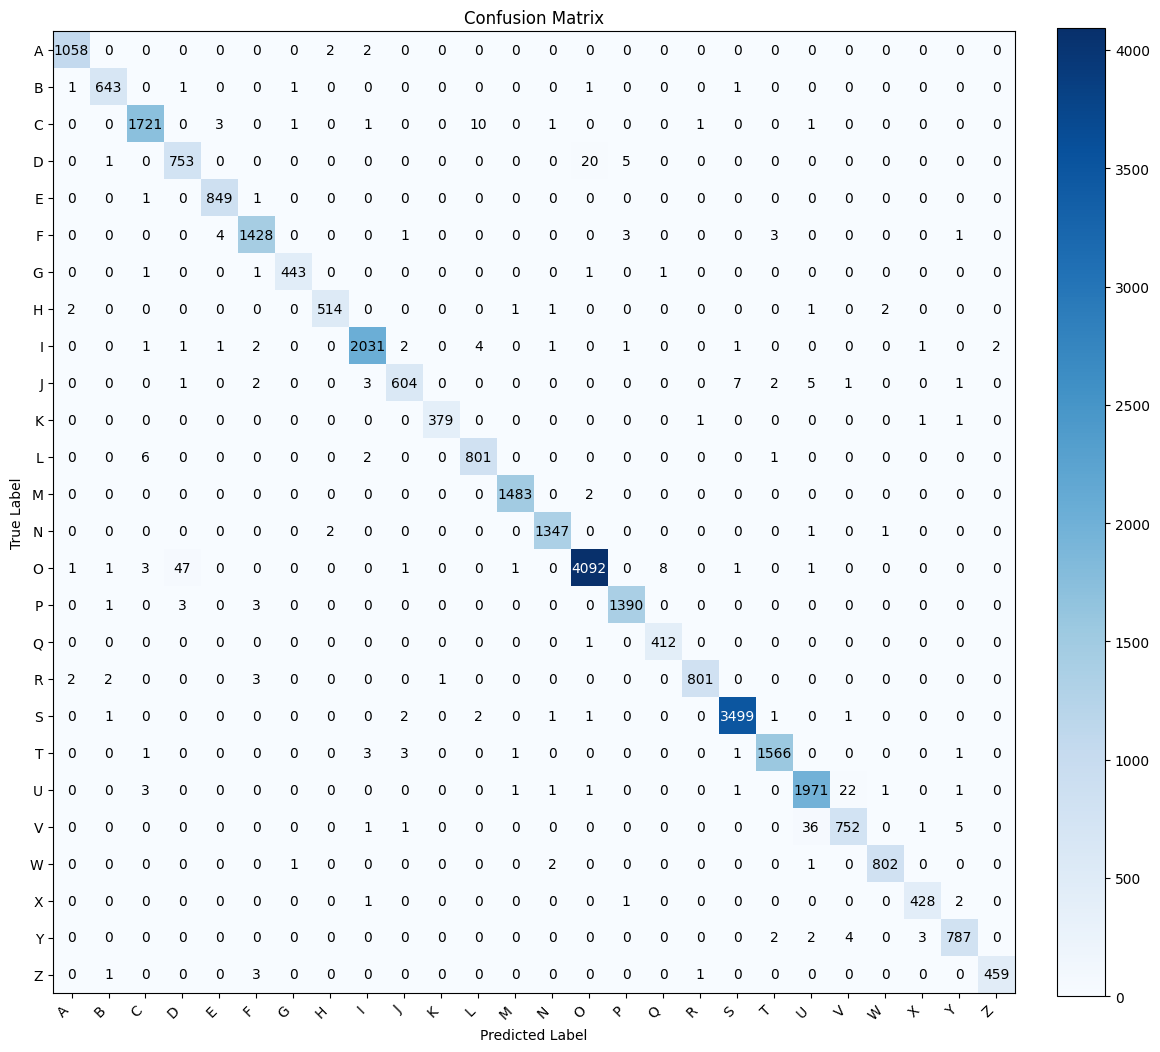

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_general(y_true, y_pred, class_labels, title="Confusion Matrix"):
    num_classes = len(class_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Dynamic figure size based on number of classes
    cell_scale = 0.45  # You can tune this for spacing
    fig_width = min(25, max(8, num_classes * cell_scale))
    fig_height = min(25, max(6, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Display matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Colorbar height matches matrix height
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)

    # Set axis labels and ticks
    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    # Adjust tick labels: auto font size and rotation
    tick_font = max(6, 12 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    # Annotate cells with counts
    fmt = 'd'
    thresh = cm.max() / 2.
    annotation_font = max(5, 12 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Example usage (in your notebook):
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix_general(y_true, y_pred, class_labels)


In [16]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")

490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
📋 Classification Report:

              precision    recall  f1-score   support

           A     0.9944    0.9962    0.9953      1062
           B     0.9892    0.9923    0.9908       648
           C     0.9908    0.9896    0.9902      1739
           D     0.9342    0.9666    0.9502       779
           E     0.9907    0.9976    0.9941       851
           F     0.9896    0.9917    0.9906      1440
           G     0.9933    0.9911    0.9922       447
           H     0.9923    0.9866    0.9894       521
           I     0.9936    0.9917    0.9927      2048
           J     0.9837    0.9649    0.9742       626
           K     0.9974    0.9921    0.9948       382
           L     0.9804    0.9889    0.9846       810
           M     0.9973    0.9987    0.9980      1485
           N     0.9948    0.9970    0.9959      1351
           O     0.9934    0.9846    0.9890      4156
           P     0.9929    0.9950    0.9939      1397
           Q 

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, precision_score, recall_score, f1_score, accuracy_score
)

# Get predictions and ground truths
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(26)]  # EMNIST digits: class names

# Generate classification report dictionary
report_dict = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True, digits=4
)

# Convert to DataFrame for display
report_df = pd.DataFrame(report_dict).transpose()

# Add overall accuracy
accuracy = accuracy_score(y_true, y_pred)
report_df.loc['accuracy'] = [accuracy, None, None, len(y_true)]

# Display per-class metrics
print("📋 Per-Class Precision, Recall, F1-Score:\n")
display(report_df.loc[class_names])  # Show only class rows

# Display overall scores
print("\n📊 Global Metrics:")
print(f"✅ Accuracy:             {accuracy:.4f}")
print(f"🔁 Precision (Macro):    {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"🔁 Recall (Macro):       {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"🔁 F1-Score (Macro):     {f1_score(y_true, y_pred, average='macro'):.4f}")

print(f"⚖️ Precision (Weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"⚖️ Recall (Weighted):    {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"⚖️ F1-Score (Weighted):  {f1_score(y_true, y_pred, average='weighted'):.4f}")

print(f"📉 Precision (Micro):    {precision_score(y_true, y_pred, average='micro'):.4f}")
print(f"📉 Recall (Micro):       {recall_score(y_true, y_pred, average='micro'):.4f}")
print(f"📉 F1-Score (Micro):     {f1_score(y_true, y_pred, average='micro'):.4f}")


490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
📋 Per-Class Precision, Recall, F1-Score:



,precision,recall,f1-score,support
0,0.994361,0.996234,0.995296,1062.0
1,0.989231,0.992284,0.990755,648.0
2,0.990789,0.989649,0.990219,1739.0
3,0.934243,0.966624,0.950158,779.0
4,0.990665,0.997650,0.994145,851.0
5,0.989605,0.991667,0.990635,1440.0
6,0.993274,0.991051,0.992161,447.0
7,0.992278,0.986564,0.989413,521.0
8,0.993640,0.991699,0.992669,2048.0
9,0.983713,0.964856,0.974194,626.0



📊 Global Metrics:
✅ Accuracy:             0.9894
🔁 Precision (Macro):    0.9875
🔁 Recall (Macro):       0.9882
🔁 F1-Score (Macro):     0.9879
⚖️ Precision (Weighted): 0.9894
⚖️ Recall (Weighted):    0.9894
⚖️ F1-Score (Weighted):  0.9894
📉 Precision (Micro):    0.9894
📉 Recall (Micro):       0.9894
📉 F1-Score (Micro):     0.9894


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions & ground truths (you already have these)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(26)]  # adjust for your classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# cm shape: (num_classes, num_classes)

num_classes = len(class_names)
sensitivities = []
specificities = []
supports = np.sum(cm, axis=1)  # Number of true samples per class

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Weighted sensitivity and specificity per class = metric * support
weighted_sensitivities = sensitivities * supports
weighted_specificities = specificities * supports

# Print results nicely
print(f"{'Class':>5} | {'Support':>7} | {'Sensitivity':>12} | {'Weighted Sensitivity':>20} | {'Specificity':>12} | {'Weighted Specificity':>20}")
print("-" * 90)
for i, cls in enumerate(class_names):
    print(f"{cls:>5} | {supports[i]:7} | {sensitivities[i]:12.4f} | {weighted_sensitivities[i]:20.4f} | {specificities[i]:12.4f} | {weighted_specificities[i]:20.4f}")


490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
Class | Support |  Sensitivity | Weighted Sensitivity |  Specificity | Weighted Specificity
------------------------------------------------------------------------------------------
    0 |    1062 |       0.9962 |            1058.0000 |       0.9998 |            1061.7896
    1 |     648 |       0.9923 |             643.0000 |       0.9998 |             647.8522
    2 |    1739 |       0.9896 |            1721.0000 |       0.9995 |            1738.0602
    3 |     779 |       0.9666 |             753.0000 |       0.9983 |             777.6493
    4 |     851 |       0.9976 |             849.0000 |       0.9997 |             850.7768
    5 |    1440 |       0.9917 |            1428.0000 |       0.9995 |            1439.2777
    6 |     447 |       0.9911 |             443.0000 |       0.9999 |             446.9566
    7 |     521 |       0.9866 |             514.0000 |       0.9999 |             520.9324
    8 |    2048 |       0.9917 |       

490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step

📋 Classification Report:

              precision    recall  f1-score   support

           A     0.9944    0.9962    0.9953      1062
           B     0.9892    0.9923    0.9908       648
           C     0.9908    0.9896    0.9902      1739
           D     0.9342    0.9666    0.9502       779
           E     0.9907    0.9976    0.9941       851
           F     0.9896    0.9917    0.9906      1440
           G     0.9933    0.9911    0.9922       447
           H     0.9923    0.9866    0.9894       521
           I     0.9936    0.9917    0.9927      2048
           J     0.9837    0.9649    0.9742       626
           K     0.9974    0.9921    0.9948       382
           L     0.9804    0.9889    0.9846       810
           M     0.9973    0.9987    0.9980      1485
           N     0.9948    0.9970    0.9959      1351
           O     0.9934    0.9846    0.9890      4156
           P     0.9929    0.9950    0.9939      1397
           Q

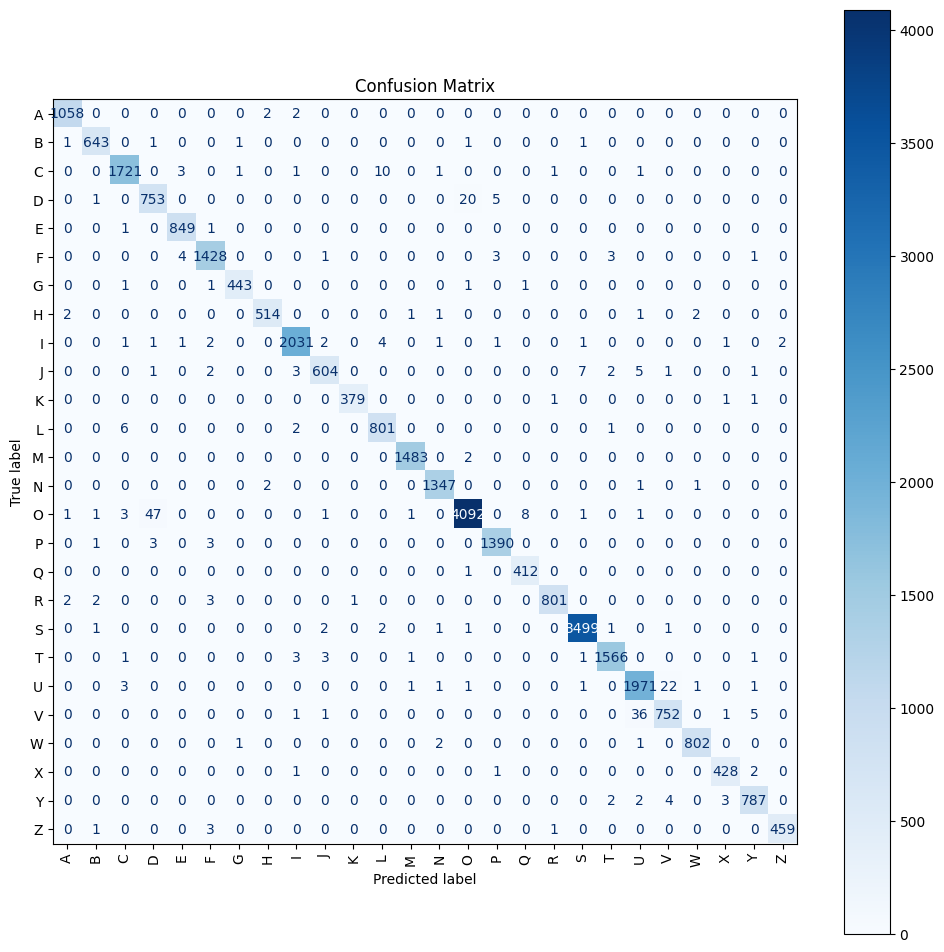


📈 ROC Curve (One-vs-Rest)


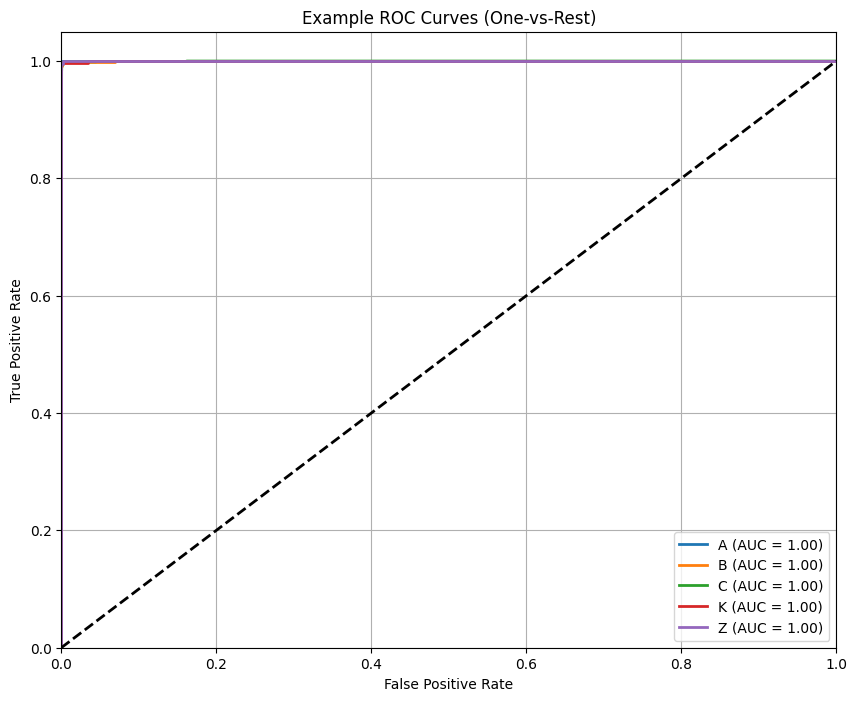

In [20]:
# Thesis Metrics and Visualization for EMNIST ByClass A-Z
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Classification Report
print("\n\U0001F4CB Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Macro & Weighted Scores
print("\n\U0001F522 Macro & Weighted Scores")
for average in ["macro", "weighted"]:
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"\n{average.capitalize()}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Per-Class Scores
print("\n\U0001F4DD Per-Class Metrics")
for i, label in enumerate(class_names):
    precision = precision_score(y_true == i, y_pred == i)
    recall = recall_score(y_true == i, y_pred == i)
    f1 = f1_score(y_true == i, y_pred == i)
    print(f"{label}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC Curve
print("\n\U0001F4C8 ROC Curve (One-vs-Rest)")
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot a few example ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, 10))
for i, c in zip([0, 1, 2, 10, 25], colors):  # change to any class indices
    plt.plot(fpr[i], tpr[i], color=c, lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Example ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step

📋 Script-Generalized Model - Classification Report:

              precision    recall  f1-score   support

           A     0.9944    0.9962    0.9953      1062
           B     0.9892    0.9923    0.9908       648
           C     0.9908    0.9896    0.9902      1739
           D     0.9342    0.9666    0.9502       779
           E     0.9907    0.9976    0.9941       851
           F     0.9896    0.9917    0.9906      1440
           G     0.9933    0.9911    0.9922       447
           H     0.9923    0.9866    0.9894       521
           I     0.9936    0.9917    0.9927      2048
           J     0.9837    0.9649    0.9742       626
           K     0.9974    0.9921    0.9948       382
           L     0.9804    0.9889    0.9846       810
           M     0.9973    0.9987    0.9980      1485
           N     0.9948    0.9970    0.9959      1351
           O     0.9934    0.9846    0.9890      4156
           P     0.9929    0.9950    0.

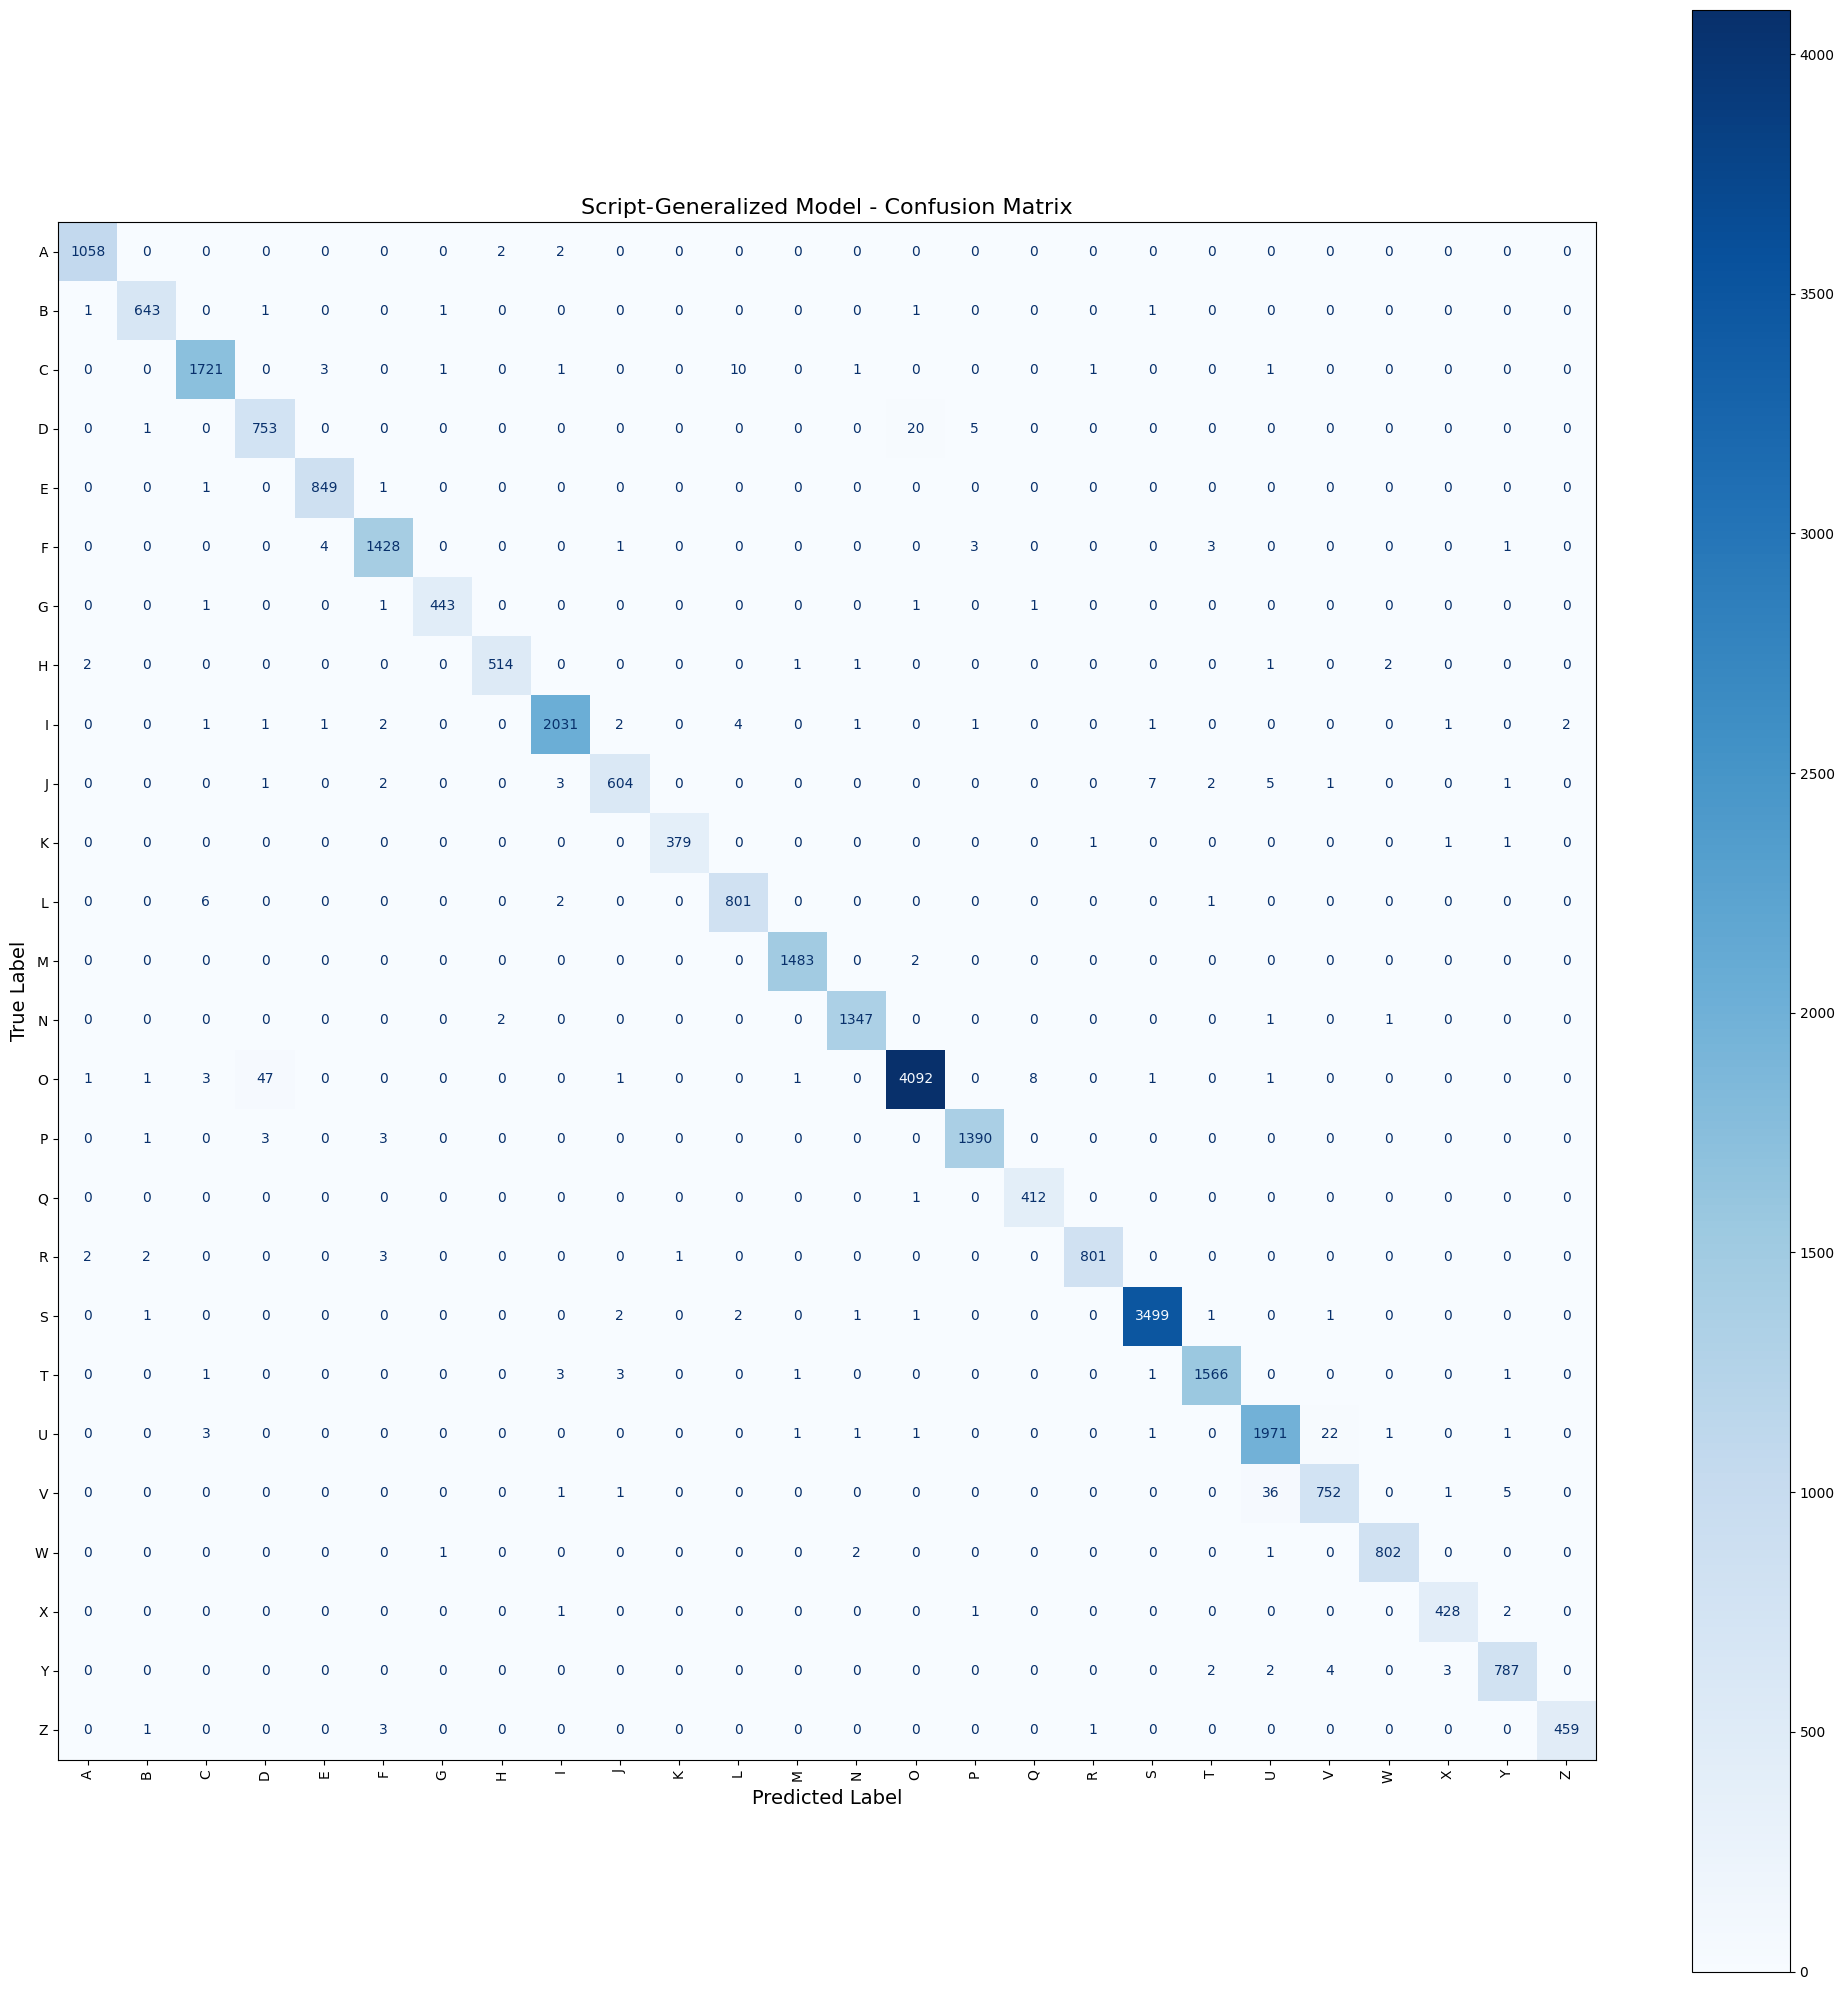


📈 Script-Generalized Model - ROC Curve:
❗ ROC Curve skipped: too many classes for clear visualization.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
)
from sklearn.preprocessing import label_binarize

def evaluate_model(model, test_generator, title_prefix="Model"):
    # Predict labels
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    n_classes = len(class_labels)

    # -------------------------------
    # Classification Report
    # -------------------------------
    report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
    print(f"\n📋 {title_prefix} - Classification Report:\n")
    print(report)

    # Macro and Weighted Scores
    scores = {
        'Precision (Macro)': precision_score(y_true, y_pred, average='macro'),
        'Recall (Macro)': recall_score(y_true, y_pred, average='macro'),
        'F1-score (Macro)': f1_score(y_true, y_pred, average='macro'),
        'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted'),
        'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted'),
        'F1-score (Weighted)': f1_score(y_true, y_pred, average='weighted'),
    }

    print(f"\n🔢 {title_prefix} - Evaluation Metrics")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")

    # -------------------------------
    # Confusion Matrix
    # -------------------------------
    cm = confusion_matrix(y_true, y_pred)
    fig_size = max(10, int(0.8 * n_classes))
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
    ax.set_title(f"{title_prefix} - Confusion Matrix", fontsize=16)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # ROC Curve
    # -------------------------------
    print(f"\n📈 {title_prefix} - ROC Curve:")
    if n_classes <= 20:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{title_prefix} - ROC Curve")
        plt.legend(loc='lower right', fontsize='small')
        plt.grid()
        plt.tight_layout()
        plt.show()
    else:
        print("❗ ROC Curve skipped: too many classes for clear visualization.")

    return scores, report, cm

# The user should run the following to evaluate:
scores, report, cm = evaluate_model(model, test_generator, title_prefix="Script-Generalized Model")



490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


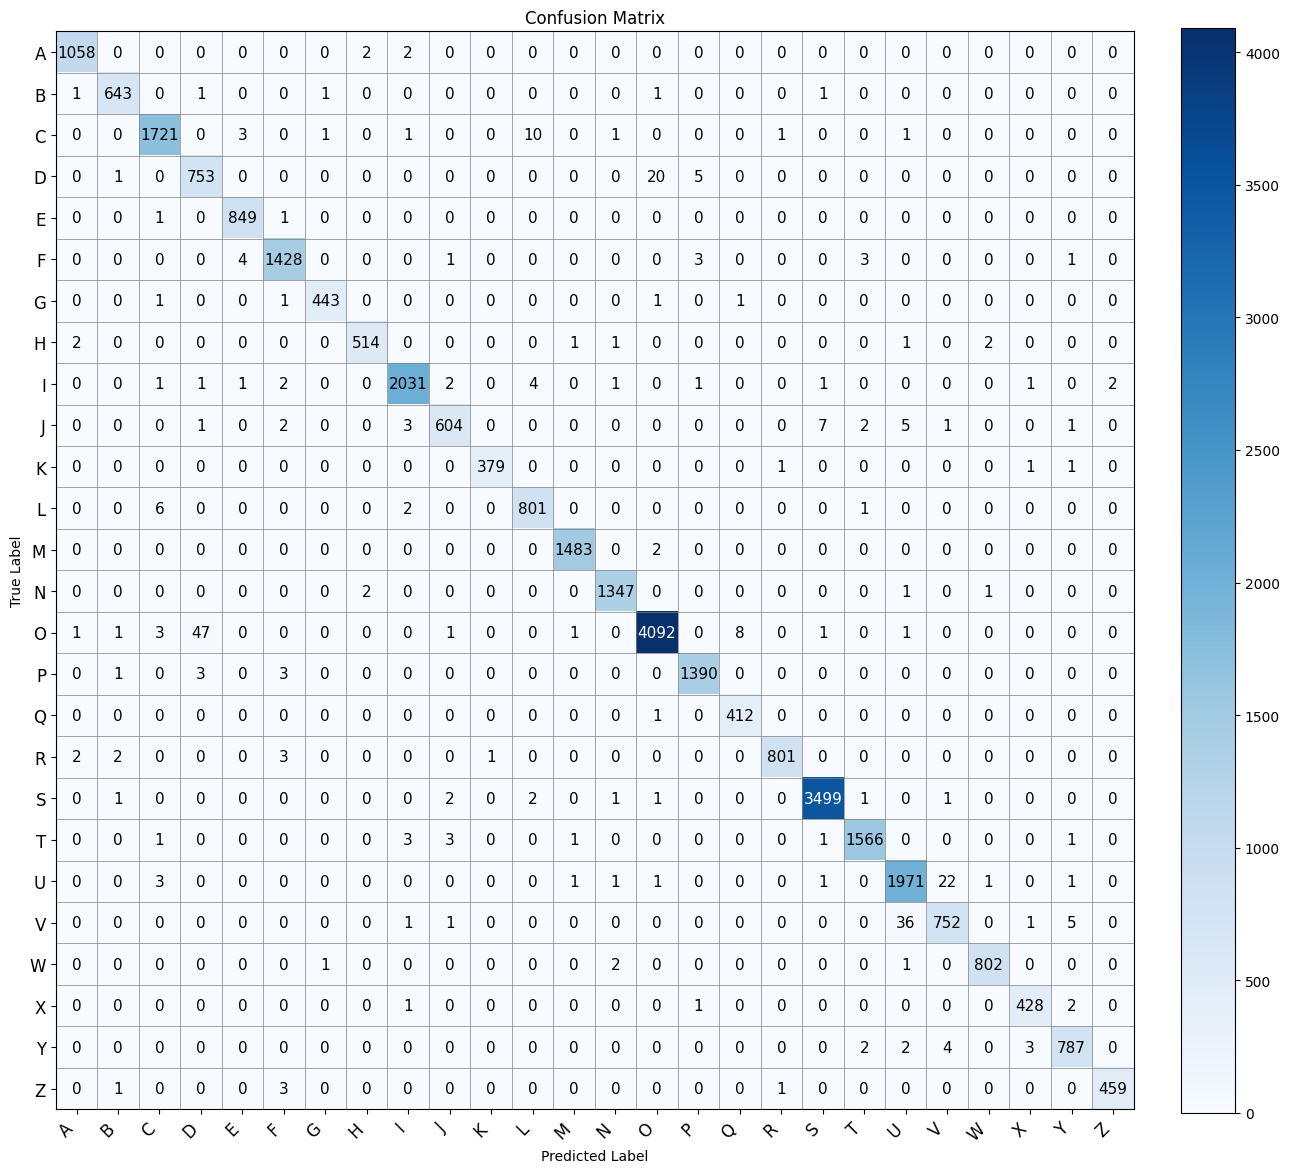

📋 Classification Report:

              precision    recall  f1-score   support

           A     0.9944    0.9962    0.9953      1062
           B     0.9892    0.9923    0.9908       648
           C     0.9908    0.9896    0.9902      1739
           D     0.9342    0.9666    0.9502       779
           E     0.9907    0.9976    0.9941       851
           F     0.9896    0.9917    0.9906      1440
           G     0.9933    0.9911    0.9922       447
           H     0.9923    0.9866    0.9894       521
           I     0.9936    0.9917    0.9927      2048
           J     0.9837    0.9649    0.9742       626
           K     0.9974    0.9921    0.9948       382
           L     0.9804    0.9889    0.9846       810
           M     0.9973    0.9987    0.9980      1485
           N     0.9948    0.9970    0.9959      1351
           O     0.9934    0.9846    0.9890      4156
           P     0.9929    0.9950    0.9939      1397
           Q     0.9786    0.9976    0.9880       413
 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score
)
import pandas as pd

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues'
):
    num_classes = len(class_labels)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_generator, threshold=0.5, plot_cm=True, normalize_cm=False):
    """
    Generalized evaluation for multi-class classifier with metrics and confusion matrix.

    Parameters:
    - model: keras or sklearn-like model with predict method.
    - test_generator: generator or dataset with .classes and .class_indices attributes.
    - threshold: threshold for ROC-AUC binary decisions (not used here but for reference).
    - plot_cm: bool, whether to plot confusion matrix.
    - normalize_cm: bool, normalize confusion matrix.

    Returns:
    - metrics_df: pandas DataFrame with per-class metrics.
    """

    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    num_classes = len(class_names)

    # 1. Confusion matrix plot
    if plot_cm:
        plot_confusion_matrix_general(y_true, y_pred, class_names, normalize=normalize_cm)

    # 2. Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 3. Macro & Weighted Precision, Recall, F1
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print("🔢 Macro Scores")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro):    {recall_macro:.4f}")
    print(f"F1-score (Macro):  {f1_macro:.4f}")

    print("\n🔢 Weighted Scores")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Weighted):    {recall_weighted:.4f}")
    print(f"F1-score (Weighted):  {f1_weighted:.4f}")

    # 4. Compute per-class Sensitivity (Recall), Specificity, Support, Weighted Sensitivity & Specificity
    cm = confusion_matrix(y_true, y_pred)
    support = cm.sum(axis=1)  # true class support

    sensitivity = np.diag(cm) / support  # recall per class
    weighted_sensitivity = sensitivity * (support / support.sum())

    # Specificity per class:
    # Specificity = TN / (TN + FP)
    # For class i:
    specificity = []
    for i in range(num_classes):
        # True Negative: sum all except row i and col i
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)
    specificity = np.array(specificity)
    weighted_specificity = specificity * (support / support.sum())

    # 5. ROC-AUC per class (one-vs-rest), if y_pred_probs available as probabilities
    roc_auc_scores = []
    try:
        from sklearn.preprocessing import label_binarize
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        # Handle edge cases with classes having only one label
        for i in range(num_classes):
            if len(np.unique(y_true_bin[:, i])) > 1:
                auc = roc_auc_score(y_true_bin[:, i], y_pred_probs[:, i])
            else:
                auc = np.nan
            roc_auc_scores.append(auc)
        roc_auc_scores = np.array(roc_auc_scores)
    except ImportError:
        roc_auc_scores = np.array([np.nan] * num_classes)

    # 6. Compose per-class metrics DataFrame
    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Support": support,
        "Sensitivity (Recall)": sensitivity,
        "Weighted Sensitivity": weighted_sensitivity,
        "Specificity": specificity,
        "Weighted Specificity": weighted_specificity,
        "ROC-AUC": roc_auc_scores,
        "Precision": [report[cls]['precision'] for cls in class_names],
        "Recall": [report[cls]['recall'] for cls in class_names],
        "F1-score": [report[cls]['f1-score'] for cls in class_names],
    })

    print("\n📊 Per-Class Metrics:\n")
    print(metrics_df.round(4))

    return metrics_df

# ========== Example usage ==========
metrics_df = evaluate_model(model, test_generator)


490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
✅ Confusion matrix saved to: confusion_matrix.png


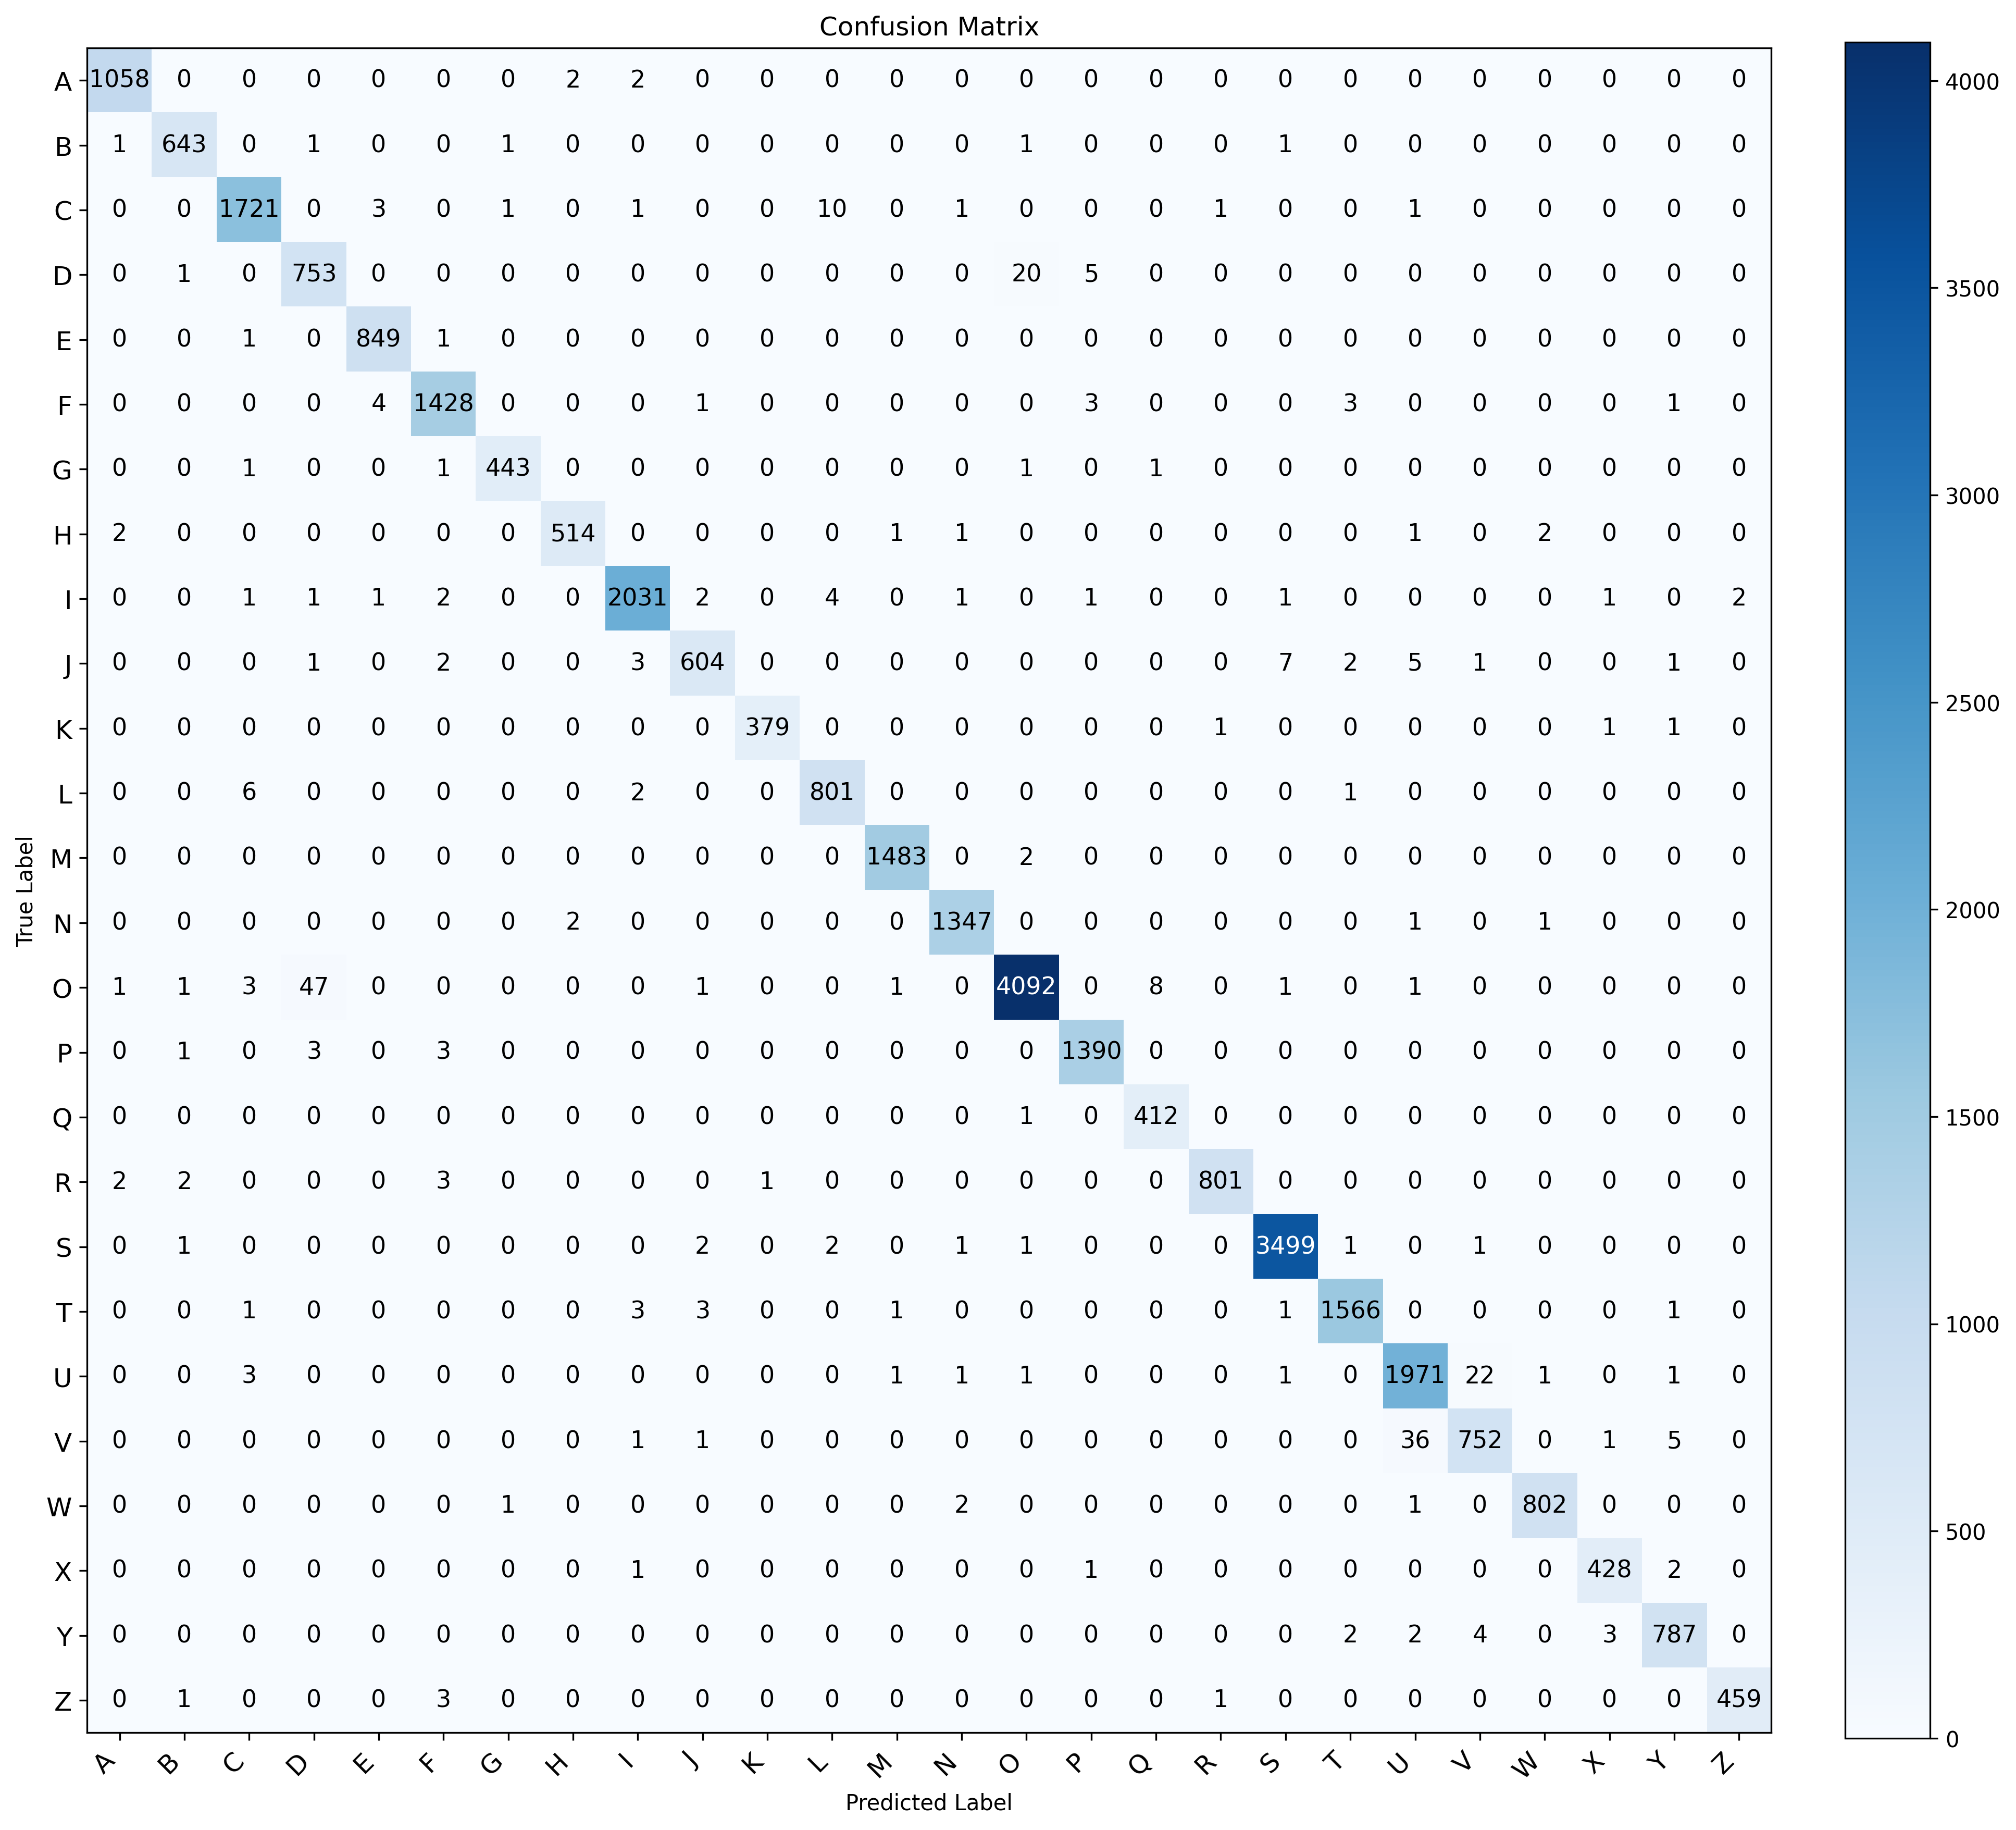

📋 Classification Report:

              precision    recall  f1-score   support

           A     0.9944    0.9962    0.9953      1062
           B     0.9892    0.9923    0.9908       648
           C     0.9908    0.9896    0.9902      1739
           D     0.9342    0.9666    0.9502       779
           E     0.9907    0.9976    0.9941       851
           F     0.9896    0.9917    0.9906      1440
           G     0.9933    0.9911    0.9922       447
           H     0.9923    0.9866    0.9894       521
           I     0.9936    0.9917    0.9927      2048
           J     0.9837    0.9649    0.9742       626
           K     0.9974    0.9921    0.9948       382
           L     0.9804    0.9889    0.9846       810
           M     0.9973    0.9987    0.9980      1485
           N     0.9948    0.9970    0.9959      1351
           O     0.9934    0.9846    0.9890      4156
           P     0.9929    0.9950    0.9939      1397
           Q     0.9786    0.9976    0.9880       413
 

/tmp/ipykernel_35/262129706.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


✅ ROC curve plot saved to: roc_curves.png


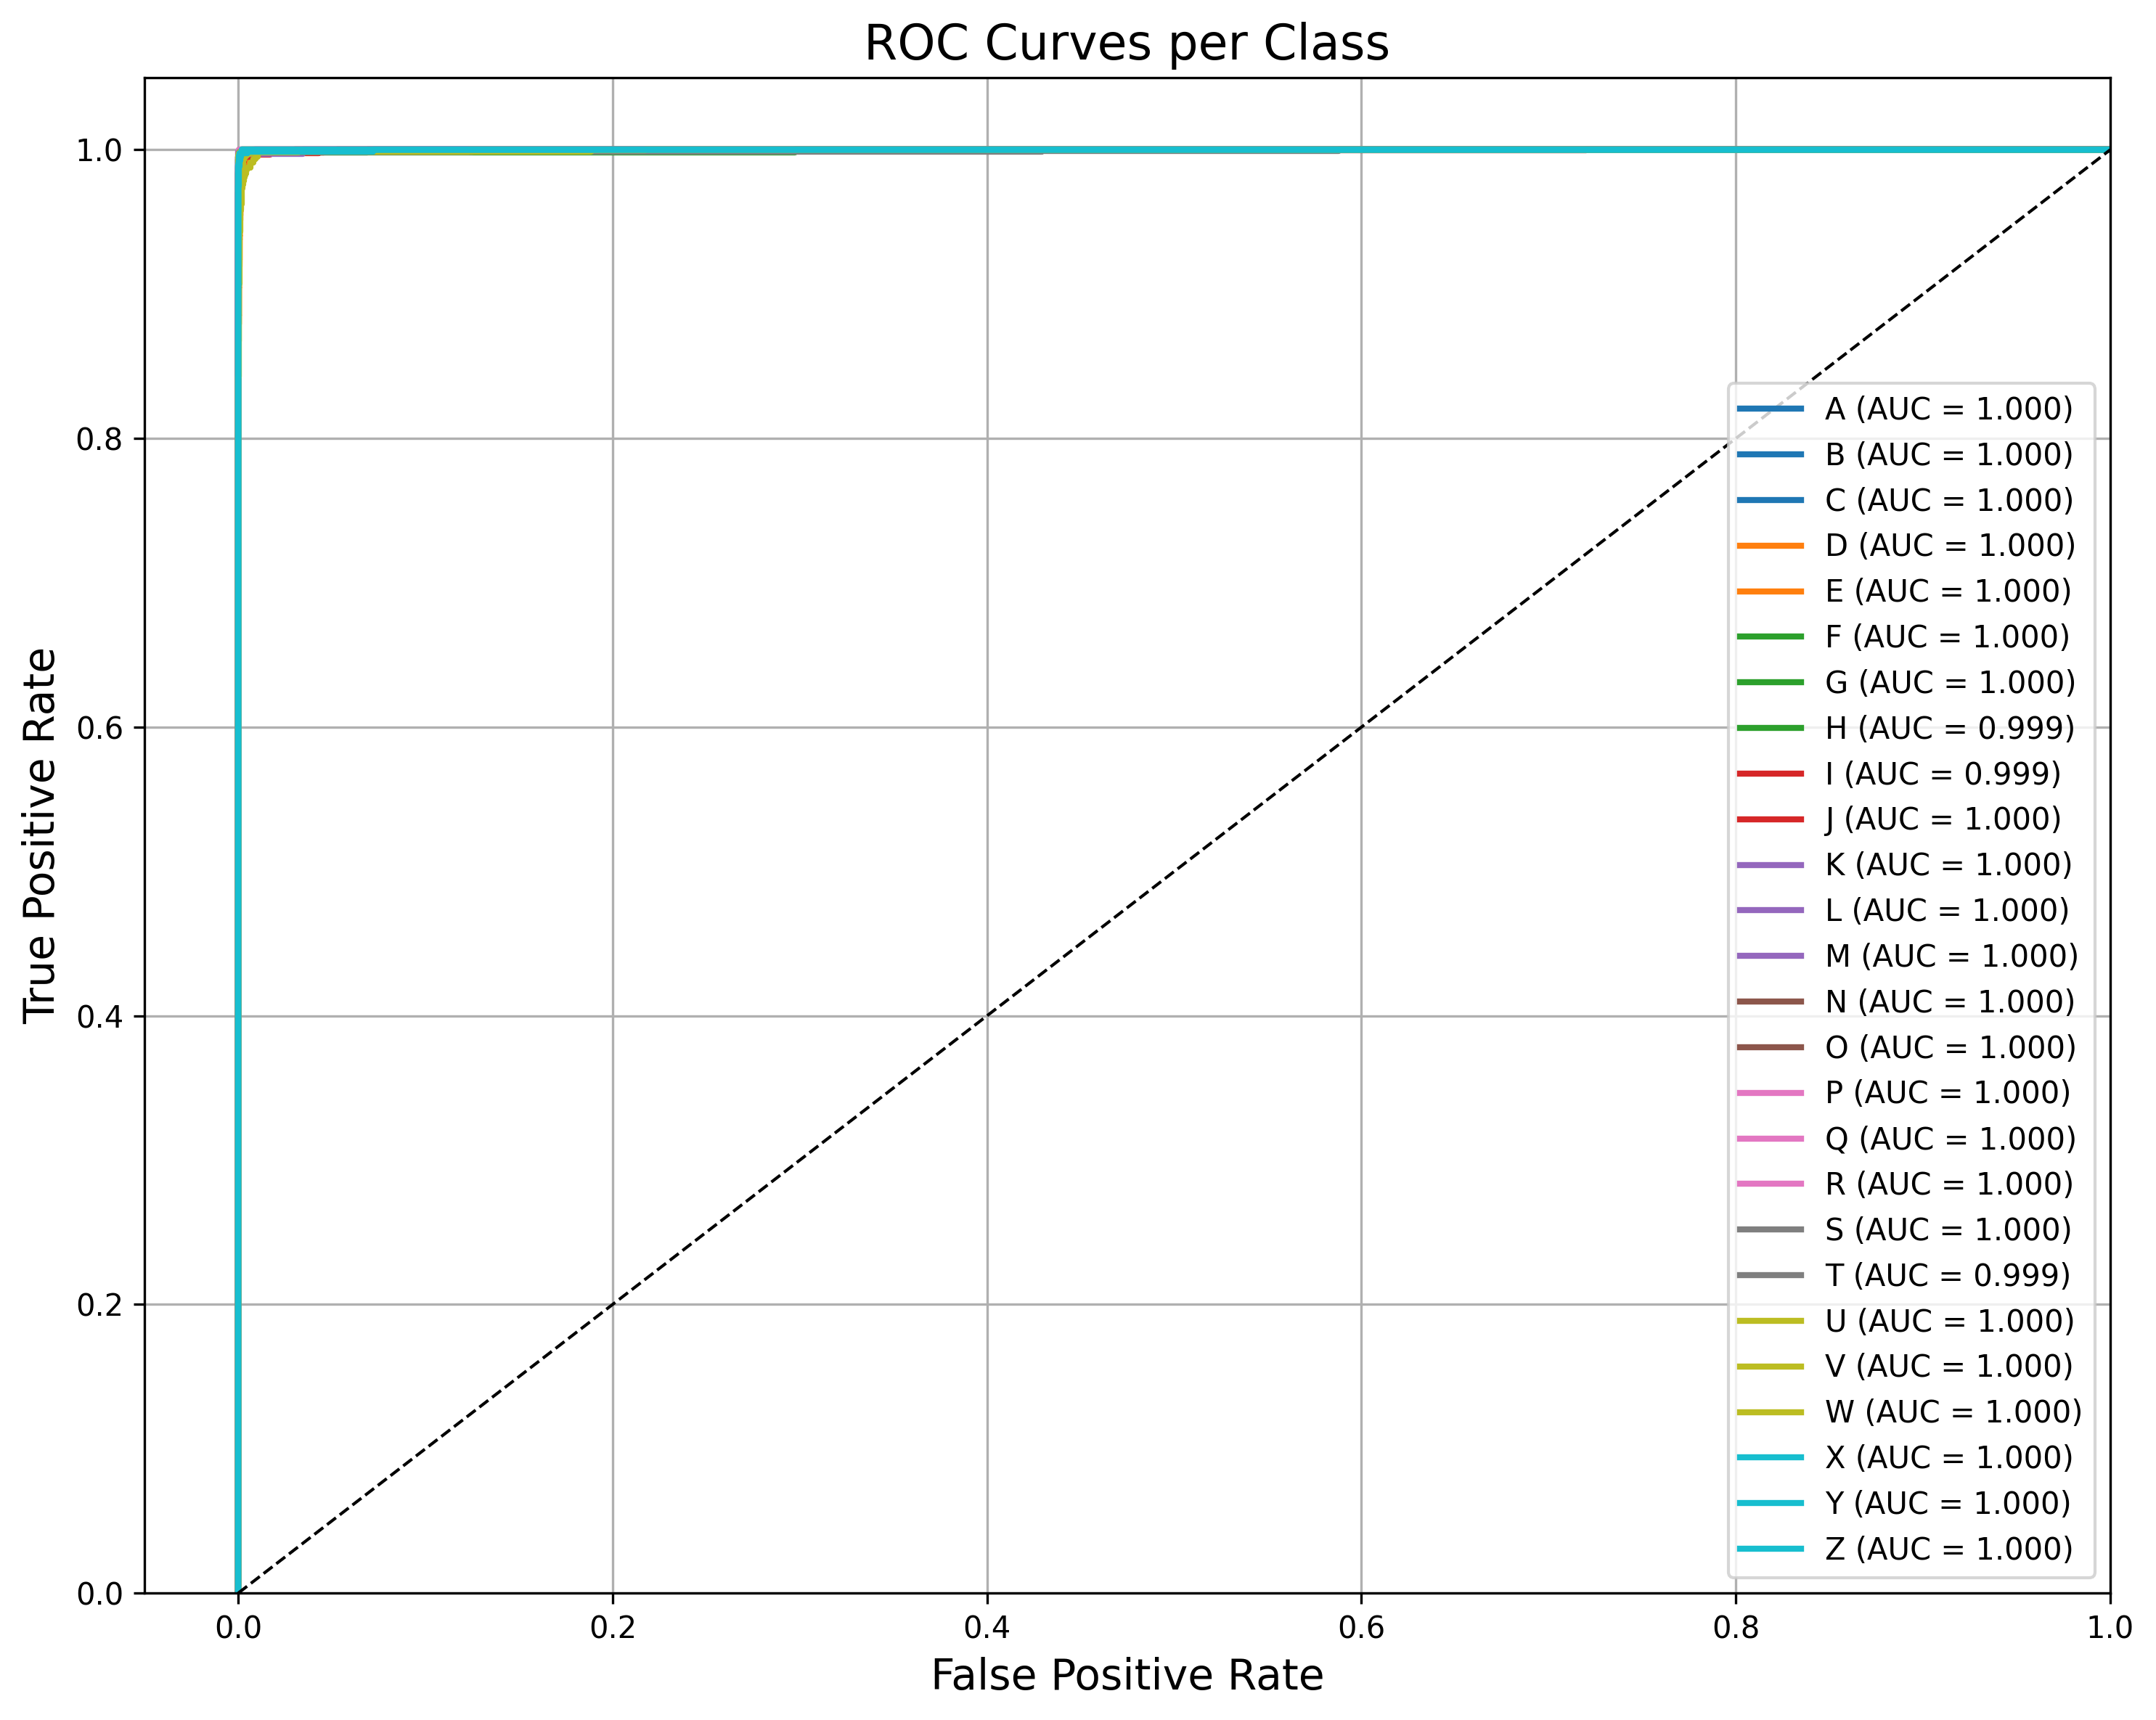

✅ Classification report metrics saved to: metrics.csv


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import pandas as pd
from sklearn.preprocessing import label_binarize

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues',
    dpi=150,       # Higher DPI for better quality
    show_grid=False  # Remove cell lines (default off)
):
    num_classes = len(class_labels)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    if show_grid:
        ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        # Disable grid & ticks for minor
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_pred_probs, class_names, dpi=150):
    """
    Plot ROC curves for each class (one-vs-rest).

    Parameters:
    - y_true: true labels (integer encoded)
    - y_pred_probs: predicted probabilities (num_samples x num_classes)
    - class_names: list of class names
    - dpi: figure dpi for quality
    """
    num_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    plt.figure(figsize=(10, 8), dpi=dpi)

    # Colors for the curves
    colors = plt.cm.get_cmap('tab10', num_classes)

    for i in range(num_classes):
        if len(np.unique(y_true_bin[:, i])) > 1:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors(i), lw=2,
                     label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
        else:
            # Class not present in true labels, skip ROC curve
            print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves per Class', fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_model(
    model, test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path=None,
    export_cm_path=None,
    export_roc_path=None
):
    """
    Generalized evaluation for multi-class classifier with metrics and confusion matrix,
    ROC curve plotting, and export capabilities.

    Parameters:
    - model: keras or sklearn-like model with predict method.
    - test_generator: generator or dataset with .classes and .class_indices attributes.
    - threshold: threshold for ROC-AUC binary decisions (not used here but for reference).
    - plot_cm: bool, whether to plot confusion matrix.
    - normalize_cm: bool, normalize confusion matrix.
    - plot_roc: bool, whether to plot ROC curves.
    - export_metrics_path: str or None, path to save metrics CSV.
    - export_cm_path: str or None, path to save confusion matrix PNG.
    - export_roc_path: str or None, path to save ROC curves PNG.

    Returns:
    - metrics_df: pandas DataFrame with per-class metrics.
    """

    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    num_classes = len(class_names)

    # 1. Confusion matrix plot
    if plot_cm:
        # Setup DPI for export or display
        dpi_val = 300 if export_cm_path else 150
        num_classes = len(class_names)
        cell_scale = 0.5
        fig_width = min(25, max(10, num_classes * cell_scale))
        fig_height = min(25, max(10, num_classes * cell_scale))

        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi_val)

        cm = confusion_matrix(y_true, y_pred)
        if normalize_cm:
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            cm_norm = cm

        im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
        cbar.ax.tick_params(labelsize=10)

        ax.set(
            xticks=np.arange(num_classes),
            yticks=np.arange(num_classes),
            xticklabels=class_names,
            yticklabels=class_names,
            xlabel='Predicted Label',
            ylabel='True Label',
            title="Confusion Matrix"
        )

        tick_font = max(7, 14 - num_classes // 10)
        rotation_angle = 45 if num_classes > 10 else 0
        plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
        plt.setp(ax.get_yticklabels(), fontsize=tick_font)

        # No grid lines as requested
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

        fmt = '.2f' if normalize_cm else 'd'
        thresh = cm_norm.max() / 2.
        annotation_font = max(6, 13 - num_classes // 10)
        for i in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                val = format(cm_norm[i, j], fmt)
                ax.text(j, i, val,
                        ha="center", va="center",
                        fontsize=annotation_font,
                        color="white" if cm_norm[i, j] > thresh else "black")

        plt.tight_layout()

        if export_cm_path:
            fig.savefig(export_cm_path, dpi=dpi_val)
            print(f"✅ Confusion matrix saved to: {export_cm_path}")

        plt.show()

    # 2. Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 3. Macro, Weighted, and Micro Precision, Recall, F1
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

    # 4. ROC Curves
    if plot_roc:
        if y_pred_probs.shape[1] == num_classes:
            dpi_val_roc = 300 if export_roc_path else 150
            plt.figure(figsize=(10, 8), dpi=dpi_val_roc)
            y_true_bin = label_binarize(y_true, classes=range(num_classes))
            colors = plt.cm.get_cmap('tab10', num_classes)
            for i in range(num_classes):
                if len(np.unique(y_true_bin[:, i])) > 1:
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, color=colors(i), lw=2,
                             label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
                else:
                    print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")
            plt.plot([0, 1], [0, 1], 'k--', lw=1)
            plt.xlim([-0.05, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=14)
            plt.ylabel('True Positive Rate', fontsize=14)
            plt.title('ROC Curves per Class', fontsize=16)
            plt.legend(loc="lower right", fontsize=10)
            plt.grid(True)
            plt.tight_layout()
            if export_roc_path:
                plt.savefig(export_roc_path, dpi=dpi_val_roc)
                print(f"✅ ROC curve plot saved to: {export_roc_path}")
            plt.show()
        else:
            print("ROC curve plotting skipped due to mismatch in prediction probabilities dimension.")

    # 5. Export metrics dataframe if path provided
    if export_metrics_path:
        # Prepare metrics DataFrame from classification report
        metrics_df = pd.DataFrame(report).transpose()
        metrics_df.to_csv(export_metrics_path)
        print(f"✅ Classification report metrics saved to: {export_metrics_path}")

    return {
        "classification_report_dict": report,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }


results = evaluate_model(
    model,
    test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path="metrics.csv",     # Optional
    export_cm_path="confusion_matrix.png", # Optional
    export_roc_path="roc_curves.png"       # Optional
)
